# Milestone 2

In [25]:
from cProfile import label

from matplotlib.pyplot import ylabel, title
from networkx.algorithms.bipartite.basic import color
from scipy.stats import binned_statistic
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# all imports
from src import *
import pandas as pd
import os.path

## Data acquisition

In [3]:
filename = './data/dataframe_2016_to_2019.csv'
start_year = 2016
end_year = 2019

if not os.path.isfile(filename):
    # Get the data from the NHL API (2016 - 2019)
    nhl_data_provider = get_data_from(start_year, end_year)

    # Clean the data
    clean_regular_season, clean_playoff = clean_data(nhl_data_provider)

    # Transform data into dataframe
    df_2016_to_2019 = convert_dictionaries_to_dataframes(clean_regular_season,
                                                     clean_playoff,
                                                     np.arange(start_year, end_year + 1).tolist())
    df_2016_to_2019.to_csv(filename, index=False)

Data was successfully imported: data/regular_season/2016\2016_0001.json
Data was successfully imported: data/regular_season/2016\2016_0002.json
Data was successfully imported: data/regular_season/2016\2016_0003.json
Data was successfully imported: data/regular_season/2016\2016_0004.json
Data was successfully imported: data/regular_season/2016\2016_0005.json
Data was successfully imported: data/regular_season/2016\2016_0006.json
Data was successfully imported: data/regular_season/2016\2016_0007.json
Data was successfully imported: data/regular_season/2016\2016_0008.json
Data was successfully imported: data/regular_season/2016\2016_0009.json
Data was successfully imported: data/regular_season/2016\2016_0010.json
Data was successfully imported: data/regular_season/2016\2016_0011.json
Data was successfully imported: data/regular_season/2016\2016_0012.json
Data was successfully imported: data/regular_season/2016\2016_0013.json
Data was successfully imported: data/regular_season/2016\2016_00

In [4]:
train_data = pd.read_csv(filename)

# Ingénierie des caractéristiques

## Question 1

In [5]:
train_data

,Year,idGame,gameType,periodType,currentPeriod,timeInPeriod,eventOwnerTeam,typeDescKey,iceCoord,zoneShoot,shootingPlayer,goaliePlayer,shotType,teamSide,emptyGoalNet,isGoalAdvantage,shotDistance,shotAngle,timeSinceLastShot
0,2016,2016020001,regular-season,REG,1/3,2016-10-12 23:01:11+00:00,Maple Leafs,shot-on-goal,"(-77, 5)",O,Mitch Marner,Craig Anderson,wrist,away,False,Neutral,13.0,3.715289,0:00
1,2016,2016020001,regular-season,REG,1/3,2016-10-12 23:02:53+00:00,Senators,shot-on-goal,"(86, 13)",O,Chris Kelly,Frederik Andersen,wrist,home,False,Neutral,13.3,8.595911,0:00
2,2016,2016020001,regular-season,REG,1/3,2016-10-12 23:04:01+00:00,Senators,shot-on-goal,"(23, -38)",N,Cody Ceci,Frederik Andersen,wrist,home,False,Neutral,76.2,58.815025,1:08
3,2016,2016020001,regular-season,REG,1/3,2016-10-12 23:04:46+00:00,Senators,shot-on-goal,"(33, -15)",O,Erik Karlsson,Frederik Andersen,slap,home,False,Neutral,58.0,24.443955,0:45
4,2016,2016020001,regular-season,REG,1/3,2016-10-12 23:06:46+00:00,Maple Leafs,shot-on-goal,"(-34, 28)",O,Martin Marincin,Craig Anderson,wrist,away,False,Neutral,61.7,39.472460,5:35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327337,2019,2019030416,playoffs,REG,3/3,2020-09-29 00:56:01+00:00,Lightning,shot-on-goal,"(-59, -24)",O,Anthony Cirelli,Anton Khudobin,snap,away,False,Disadvantage,38.4,22.135492,7:30
327338,2019,2019030416,playoffs,REG,3/3,2020-09-29 00:57:20+00:00,Lightning,shot-on-goal,"(-81, 3)",O,Blake Coleman,Anton Khudobin,wrist,away,False,Disadvantage,8.5,2.121096,1:19
327339,2019,2019030416,playoffs,REG,3/3,2020-09-29 00:58:50+00:00,Stars,shot-on-goal,"(34, -6)",O,John Klingberg,Andrei Vasilevskiy,snap,home,False,Advantage,55.3,10.007980,3:23
327340,2019,2019030416,playoffs,REG,3/3,2020-09-29 00:59:27+00:00,Stars,shot-on-goal,"(31, 10)",O,John Klingberg,Andrei Vasilevskiy,wrist,home,False,Advantage,58.9,17.878697,0:37


In [44]:
train_data['isGoal'] = train_data['typeDescKey'].apply(lambda x: 1 if x == 'goal' else 0)

train_data['emptyGoalNet_0_1'] = train_data['emptyGoalNet'].astype(int)

train_data

,Year,idGame,gameType,periodType,currentPeriod,timeInPeriod,eventOwnerTeam,typeDescKey,iceCoord,zoneShoot,...,goaliePlayer,shotType,teamSide,emptyGoalNet,isGoalAdvantage,shotDistance,shotAngle,timeSinceLastShot,isGoal,emptyGoalNet_0_1
0,2016,2016020001,regular-season,REG,1/3,2016-10-12 23:01:11+00:00,Maple Leafs,shot-on-goal,"(-77, 5)",O,...,Craig Anderson,wrist,away,False,Neutral,13.0,3.715289,0:00,0,0
1,2016,2016020001,regular-season,REG,1/3,2016-10-12 23:02:53+00:00,Senators,shot-on-goal,"(86, 13)",O,...,Frederik Andersen,wrist,home,False,Neutral,13.3,8.595911,0:00,0,0
2,2016,2016020001,regular-season,REG,1/3,2016-10-12 23:04:01+00:00,Senators,shot-on-goal,"(23, -38)",N,...,Frederik Andersen,wrist,home,False,Neutral,76.2,58.815025,1:08,0,0
3,2016,2016020001,regular-season,REG,1/3,2016-10-12 23:04:46+00:00,Senators,shot-on-goal,"(33, -15)",O,...,Frederik Andersen,slap,home,False,Neutral,58.0,24.443955,0:45,0,0
4,2016,2016020001,regular-season,REG,1/3,2016-10-12 23:06:46+00:00,Maple Leafs,shot-on-goal,"(-34, 28)",O,...,Craig Anderson,wrist,away,False,Neutral,61.7,39.472460,5:35,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327337,2019,2019030416,playoffs,REG,3/3,2020-09-29 00:56:01+00:00,Lightning,shot-on-goal,"(-59, -24)",O,...,Anton Khudobin,snap,away,False,Disadvantage,38.4,22.135492,7:30,0,0
327338,2019,2019030416,playoffs,REG,3/3,2020-09-29 00:57:20+00:00,Lightning,shot-on-goal,"(-81, 3)",O,...,Anton Khudobin,wrist,away,False,Disadvantage,8.5,2.121096,1:19,0,0
327339,2019,2019030416,playoffs,REG,3/3,2020-09-29 00:58:50+00:00,Stars,shot-on-goal,"(34, -6)",O,...,Andrei Vasilevskiy,snap,home,False,Advantage,55.3,10.007980,3:23,0,0
327340,2019,2019030416,playoffs,REG,3/3,2020-09-29 00:59:27+00:00,Stars,shot-on-goal,"(31, 10)",O,...,Andrei Vasilevskiy,wrist,home,False,Advantage,58.9,17.878697,0:37,0,0


In [45]:
count_table = pd.crosstab(train_data['isGoal'],train_data['typeDescKey'])
# count_table2 = pd.crosstab(train_data['emptyGoalNet_0_1'],train_data['emptyGoalNet'])

count_table
# count_table2

typeDescKey,goal,shot-on-goal
isGoal,,
0,0,296406
1,30936,0


#### Histogramme du nombre de tirs (buts et non-buts séparés), regroupés par distance

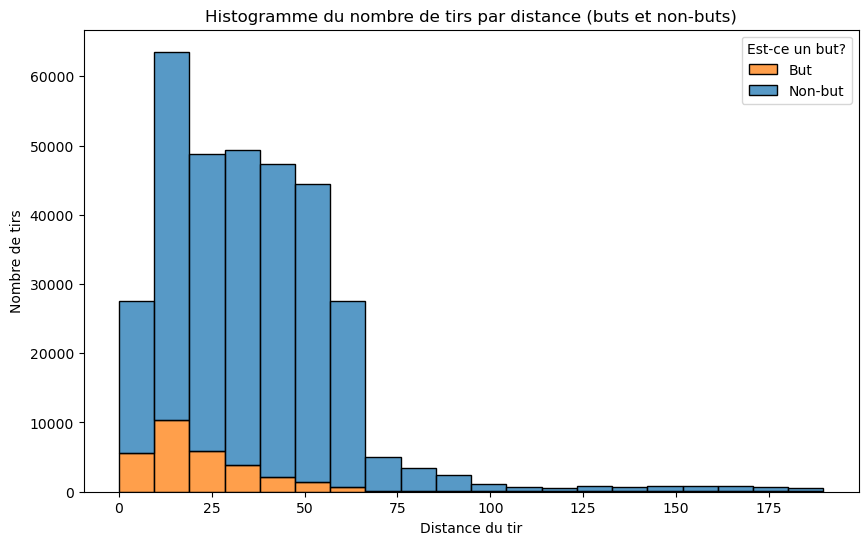

In [37]:
## Add in advancedVisualisation (by Youry)
def histogram_2_variables(df, x, hue, bins, xlabel, ylabel, title, legendTitle, legendLabels):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=x, hue=hue, bins=bins, multiple='stack')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(title=legendTitle, labels=legendLabels)
    plt.show()
    
histogram_2_variables(df=train_data, x='shotDistance', hue='isGoal', bins=20, xlabel='Distance du tir', ylabel='Nombre de tirs', title='Histogramme du nombre de tirs par distance (buts et non-buts)', legendTitle='Est-ce un but?', legendLabels=['But', 'Non-but'])

#### Histogramme du nombre de tirs (buts et non-buts séparés), regroupés par angle

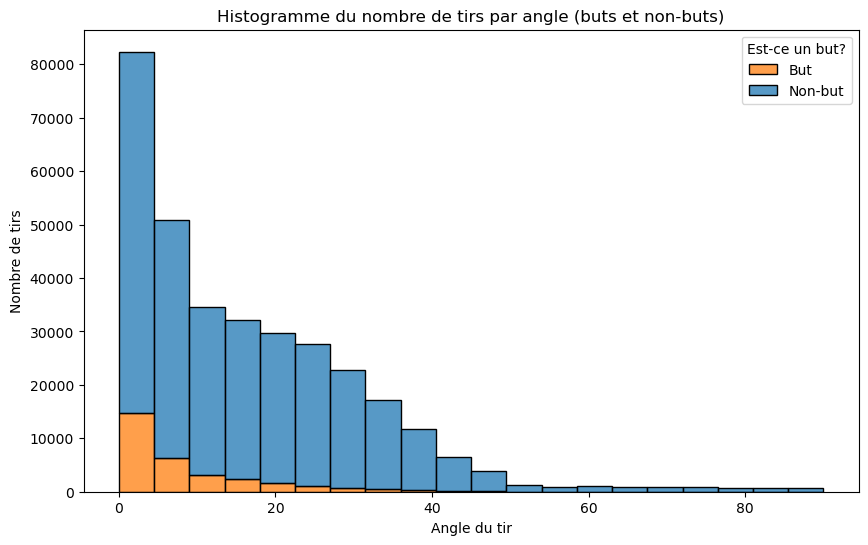

In [39]:
histogram_2_variables(train_data, x='shotAngle', hue='isGoal', bins=20, xlabel='Angle du tir', ylabel='Nombre de tirs', title='Histogramme du nombre de tirs par angle (buts et non-buts)', legendTitle='Est-ce un but?', legendLabels=['But', 'Non-but'])

#### Histogramme 2D où un axe est la distance et l'autre est l'angle (sans distinction entre buts et non-buts)

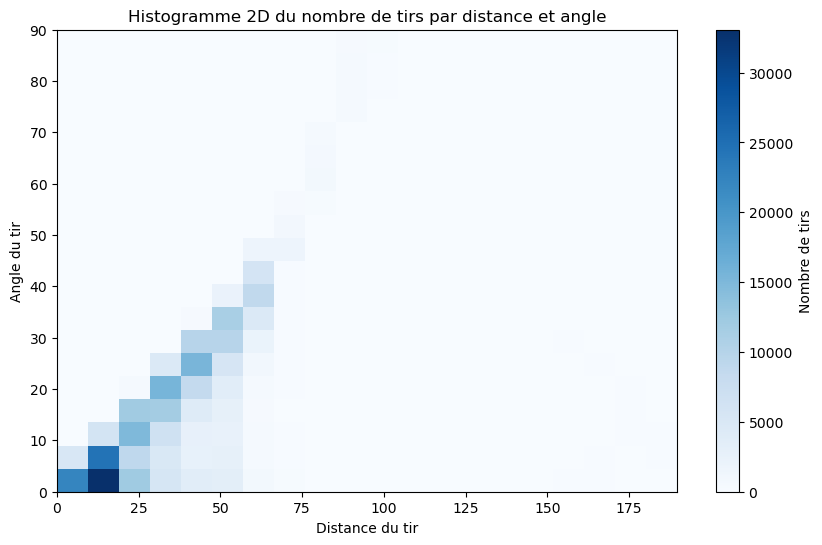

In [48]:
def histogram2D_2_variables(df, x, y, bins, label, xlabel, ylabel, title):
    # Remove rows with NaN values
    df = df.dropna(subset=[x, y])    
    # Plot the histogram with hue for 'is_goal'
    plt.figure(figsize=(10, 6))
    plt.hist2d(df[x], df[y], bins=bins, cmap='Blues')    
    # Customize legend labels for hue values
    plt.colorbar(label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

histogram2D_2_variables(train_data, x='shotDistance', y='shotAngle', bins=20, label='Nombre de tirs', xlabel='Distance du tir', ylabel='Angle du tir', title='Histogramme 2D du nombre de tirs par distance et angle')

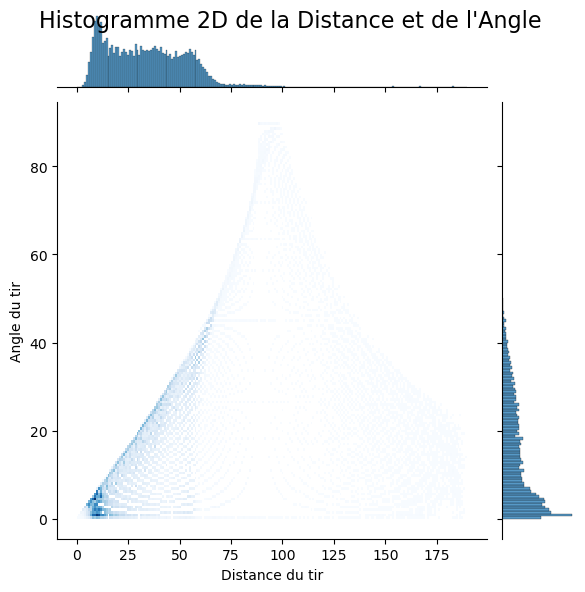

In [54]:
def histogram2D_2_variables_seaborn(df, x, y, kind, title, xlabel, ylabel):    
    # Remove rows with NaN values
    # df = df.dropna(subset=[x, y])
    # Jointplot to visualize the 2D histogram
    sns.jointplot(data=df, x=x, y=y, kind=kind, cmap='Blues')    
    # Add title and labels
    plt.suptitle(title, fontsize=16)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)    
    # Show the plot
    plt.show()

histogram2D_2_variables_seaborn(train_data, x='shotDistance', y='shotAngle', kind='hist', title="Histogramme 2D de la Distance et de l'Angle", xlabel='Distance du tir', ylabel='Angle du tir')

## Question 2

#### Le taux de but (buts / (buts + non-buts)) par distance

In [60]:
df_distance_goal_rate = train_data.groupby('shotDistance')['isGoal'].mean().reset_index()
df_distance_goal_rate.columns = ['shotDistance', 'goalRate']

df_distance_goal_rate


,shotDistance,goalRate
0,0.0,1.000000
1,1.0,1.000000
2,1.4,0.777778
3,2.0,0.500000
4,2.2,0.550000
...,...,...
1769,188.0,0.500000
1770,188.1,0.000000
1771,188.2,0.000000
1772,188.4,0.000000


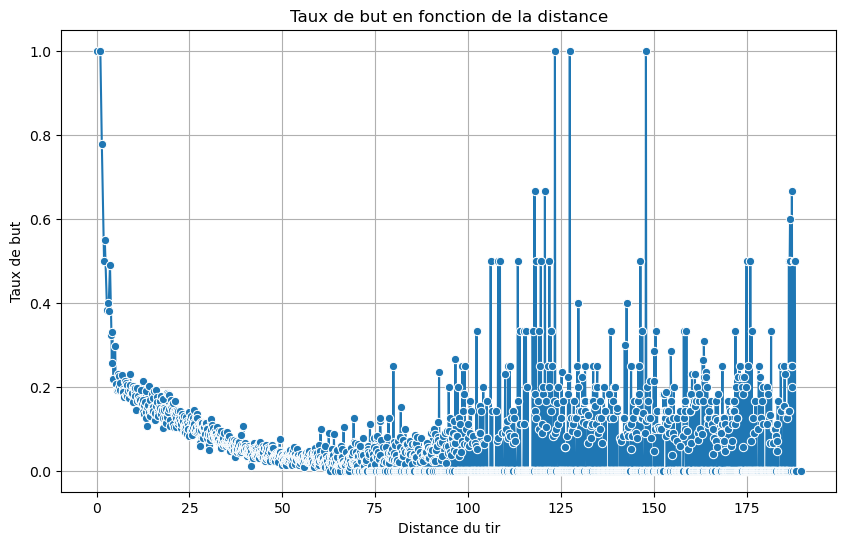

In [61]:
def lineplot_2_variables(df, x, y, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x=x, y=y, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

lineplot_2_variables(df=df_distance_goal_rate, x='shotDistance', y='goalRate', title='Taux de but en fonction de la distance', xlabel='Distance du tir', ylabel='Taux de but')

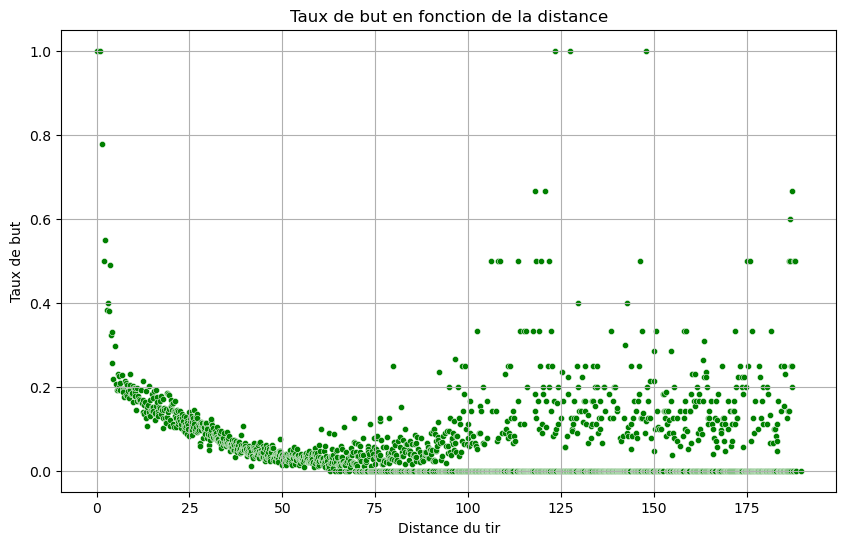

In [67]:
def scatterplot_2_variables(df, x, y, color, s, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=x, y=y, color=color, s=s, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

scatterplot_2_variables(df=df_distance_goal_rate, x='shotDistance', y='goalRate',color='green', s=20, title='Taux de but en fonction de la distance', xlabel='Distance du tir', ylabel='Taux de but')

#### Le taux de but (buts / (buts + non-buts)) par angle

In [68]:
df_angle_goal_rate = train_data.groupby('shotAngle')['isGoal'].mean().reset_index()
df_angle_goal_rate.columns = ['shotAngle', 'goalRate']

df_angle_goal_rate


,shotAngle,goalRate
0,0.000000,0.182048
1,0.584631,0.000000
2,0.596809,0.500000
3,0.636594,1.000000
4,0.651060,0.666667
...,...,...
2602,88.492564,0.074074
2603,88.531199,0.090909
2604,88.567904,0.000000
2605,88.602819,0.000000


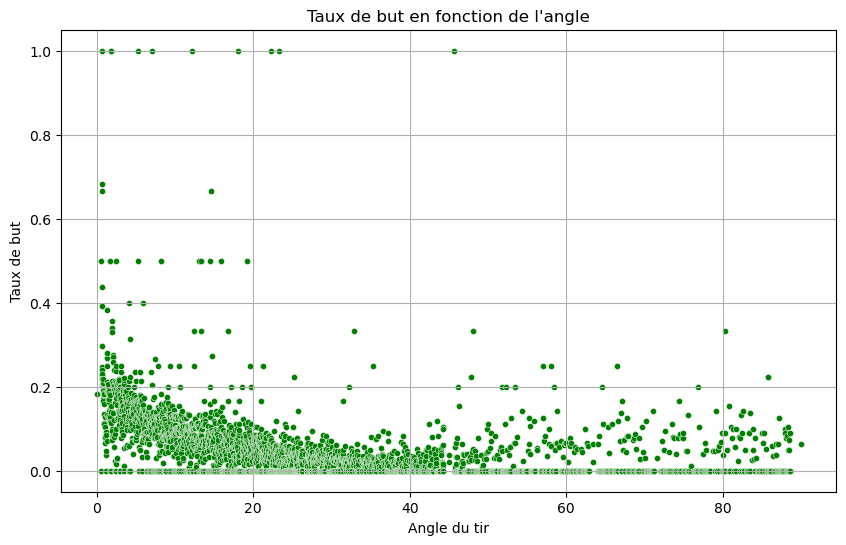

In [71]:
scatterplot_2_variables(df=df_angle_goal_rate, x='shotAngle', y='goalRate',color='green', s=20, title='Taux de but en fonction de l\'angle', xlabel='Angle du tir', ylabel='Taux de but')

## Question 3

In [ ]:
plot_goals_by_distance(train_data)